In [1]:
CODE_PATH = '.' #usually
DATA_PATH = 'E:\\test\\data_example' #path with the parsed channels
OUTPUT_FOLDER = 'E:\\test\\test'
WAVE_CLUS_PATH = 'I:\\My Drive\\doctorado\\Fer Chaure\\BCM-EMU\\wave_clus_BCM'
%cd $DATA_PATH

E:\test\data_example


### Notes
- When a preprocessing function is applied to a recording like: ```filtered_recording = st.preprocessing.bandpass_filter(recording)```. *filtered_recording* is not fully calculated, and it will be calculated only when it is required. 
- To force a recording to be calculated and saved in a temporal file on disk, the fuction CacheRecordingExtractor shoulbe be used: ```filtered_recording_c = filtered_recording.save()```. *filtered_recording_c* is fully calculated. This is the best option to generate different preprocessing alternatives.
- The custom codes here follow the same design choices than spikeinterface.
- To connect with the mountainlab pipeline any recording can be exported to an .mda file running: ```se.MdaRecordingExtractor.write_recording(recording,save_path=save_path,raw_fname=raw_fname,dtype='float')```. That will save the *recording* on the folder *save_path* with the name *raw_fname*.
- You can see more info about the function running its name with a '?' in a cell like: ```se.MdaRecordingExtractor.write_recording?```

#### Folder Structure

Example for recording with just channel 55
<pre>
📦OUTPUT_FOLDER
 ┣ 📂full_recording              #temporary folder with the filtered recording.
 ┣ 📜recording.json              #file describing data to reproduce filtering.
 ┣ 📂sortings
 ┃ ┗ 📂55
 ┃    ┗ 📂waveclus
 ┃       ┣ 📜times_results.mat  #sorting result.
 ┃       ┗ 📜spikeinterface_recording.json  #it describes the filtering for that channel.
 ┣ 📂wf_ch_55
 ┃ ┗ 📂quality_metrics
 ┃    ┗ 📜metrics.csv           #metrics.
 ┣ 📜unit_ch55_0.png             #figure showing units waveforms and ISIs.
 ┗ 📜unit_ch55_1.png             #figure showing more units waveforms and ISIs.
</pre>

In [2]:
# (not needed for this pipeline) this cell is usefull for edit a library and automatically load the updated library
# It could affect performance 
%load_ext autoreload
%autoreload 2

In [3]:
from sys import path
path.insert(0, CODE_PATH) # adds code folder to path
from custom_recording_extractors import NSXRecordingExtractor
from aux_functions import same_probe_collisions, create_waveform_extractors_by_channel, \
    plot_sorting_results, load_waveforms_extractors 
import numpy as np
from pathlib import Path
from shutil import rmtree
import os
import spikeinterface as si
import preprocessing_functions as pf
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
ss.WaveClusSorter.set_waveclus_path(WAVE_CLUS_PATH) #Set waveclus code path on spikeinterface
import spikeinterface.extractors as se
import spikeinterface.widgets as sw
import spikeinterface_gui
import ipywidgets as widgets
from IPython.display import display

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120 #better matplotlib in jupyter
mpl.rcParams['font.size'] = 10 #better matplotlib in jupyter


Setting WAVECLUS_PATH environment variable for subprocess calls to: I:\My Drive\doctorado\Fer Chaure\BCM-EMU\wave_clus_BCM


**From here you can go to [Quality Metrics](#Quality_Metrics) if the sorting is already calculated**

In [18]:
#This load the recording with a vector of channels as the input
# remember that range function in python do not include the right border
# np.concatenate([np.arange(3,9),np.arange(99,104)])  includes channes 3,4,5,6,7,8 and 99,100,101,102,103
channels = np.concatenate([np.arange(2038,2041),[2049]])
recording = NSXRecordingExtractor(channels=channels, folder_path='.')

##### NSXRecordingExtractor notes

- Use the current path ('.'), this is important to reproduce the recording later using just the json descripction. Otherwise the fullpath will be saved as the NSXRecordingExtractor input and moving the files will generate incompatibilities.

- The channes got a meaningless location based on their labels, channels in the same probe will be closer than channels in diferent probes.

In [ ]:
#(not needed for this pipeline) run this cell to write the raw recording on mda format
se.MdaRecordingExtractor.write_recording(recording, save_path=Path(OUTPUT_FOLDER),dtype='float',raw_fname='raw.mda')

***
### Notch Filter

The following cell create and save recording_notched that removes peaks in the spectrum using the calculated notches previusly saved in pre_processing_info.mat. This change could improve the mountainlab pipeline.

In [6]:
#apply calculed notches
recording_notched = pf.filter_freq_peaks(recording, load_mat_notches=True)

***
### Bandpass Filter

In [7]:
recording_filtered = st.preprocessing.bandpass_filter(recording_notched, freq_min=300, freq_max=3000, filter_order=2)

In [ ]:
# (not needed for this pipeline, just an example) run this cell to write the filtered recording on mda format
se.MdaRecordingExtractor.write_recording(recording_filtered, save_path=Path(OUTPUT_FOLDER),dtype='float',raw_fname='filt.mda')

***
### Whittening

```st.whiten(recording, by_property=None)```

Parameters:

- by_property: How to group the channels. If ```by_property=None``` all the channels will be used and masked together (like mountainlab pipeline). ```by_property='probe'``` each probe done separately, ```by_property='ch_id'``` each channel done separately.

In [ ]:
# (not needed for this pipeline)
recording_whiten = st.whiten(recording_filtered, by_property=None) #simil mountainlab pipeline
recording_whiten = recording_whiten.save()

#### Saving the recording

In [19]:
#The next line saves all the preprocessing steps to preprocess the recording. 
# The json file can be loaded later to obtain the preprocessed recording
recording_filtered.dump_to_json(file_path=OUTPUT_FOLDER/Path('recording.json'))

In [7]:
#(not needed) to reproduce the recording load the json file :
recording_filtered = si.load_extractor(file_or_folder_or_dict=OUTPUT_FOLDER/Path('recording.json'))

##### Saving all the data for sorting experimentation

In [8]:
# spikeinterface will recalculate the filtering each time we ask for data,
# to write on disk the preprocessed recording, run: 

recording_filtered = recording_filtered.save(folder=OUTPUT_FOLDER/Path('full_recording'))
# this is a temporary file, just to improve waveforms calculatios. The folder will be deleted later.

write_binary_recording with n_jobs 1  chunk_size None


In [5]:
# (not needed) Usefull to fast load the recording
# the already calculated recording can be loaded from the temporary folder with:
recording_filtered = si.load_extractor(file_or_folder_or_dict=OUTPUT_FOLDER/Path('full_recording'))
# the folder could be removed after finishing the pipeline

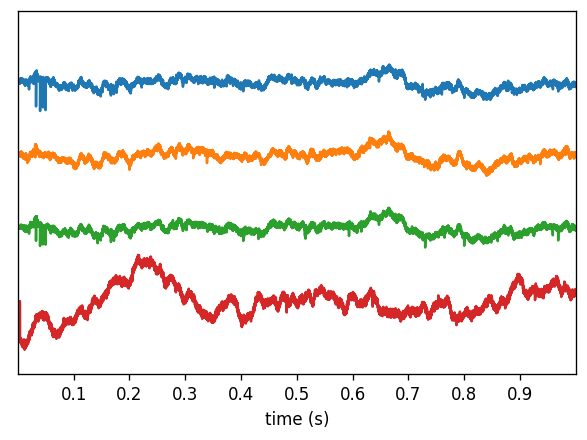

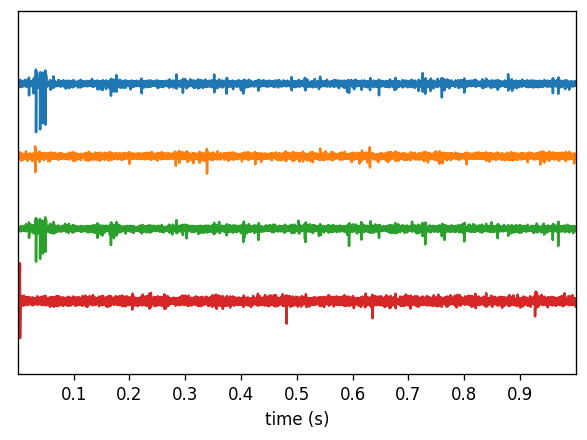

In [9]:
# (not needed, just to show widgets)
# plot first second of raw data and filtered data
sw.plot_timeseries(recording, time_range=(0, 1))
sw.plot_timeseries(recording_filtered, time_range=(0, 1))

### Sorting with Wave_clus

##### Usage
Call sorter:

```ss.run_sorter_by_property(sorter_name='waveclus',recording=recording_filtered, detect_threshold=4.5, detect_sign=-1, enable_detect_filter=False, enable_sort_filter=False, grouping_property='channel', working_folder=OUTPUT_FOLDER,mode_if_folder_exists='overwrite',engine='joblib')```                      

Parameters:

- detect_threshold: threshold to use
- enable_detect_filter: set as False because you don't want to filter the signal again just for detecction.
- enable_sort_filter: set as False because the raw signal is already filtered.
- grouping_property: set as 'channel' to sort each channel independently


In [11]:
ss.run_sorter_by_property(sorter_name='waveclus',recording=recording_filtered, detect_threshold=4.5, detect_sign=-1, enable_detect_filter=False, enable_sort_filter=False, grouping_property='channel', working_folder=OUTPUT_FOLDER/Path('sortings'),mode_if_folder_exists='overwrite',engine='joblib')
# Then rename auxiliary waveclus files and allow manual curation using temperature plot
# and remove the copy of the filtered recording used by wave_clus
for ch in recording_filtered.get_channel_ids():
    resfolder = OUTPUT_FOLDER/Path('sortings')/Path(str(ch))/Path('waveclus')
    os.rename(resfolder/Path('data_raw1.dg_01.lab'),resfolder/Path('data_results.dg_01.lab'))
    os.rename(resfolder/Path('data_raw1.dg_01'),resfolder/Path('data_results.dg_01'))
    os.remove(resfolder/Path('raw1.h5'))

## <a id='Quality_Metrics'>Quality_Metrics</a>
 
First some waveforms should be extracted from the recording

In [19]:
#This lines could be run just after importing spikeinterface and moving to the data folder.
#loads recording from temporary folder
recording_filtered = si.load_extractor(file_or_folder_or_dict=OUTPUT_FOLDER/Path('full_recording'))
#loads sortings
sorting_all = ss.run_sorter_by_property(sorter_name='waveclus',recording=recording_filtered, grouping_property='channel', working_folder=OUTPUT_FOLDER/Path('sortings'),mode_if_folder_exists='keep')


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.93.0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.93.0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.93.0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.93.0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.93.0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.93.0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.93.0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.93.0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.93.0


f:\github\spikeinterface\spikeinterface\core\unitsaggregationsorting.py:71: UserWarning: Cannot propagate registered recording to UnitsAggregationSorting
  warnings.warn(


In [41]:
recompute_chs = [] #list of the channels to recompute. empty to recompute all.
waveforms_ch = create_waveform_extractors_by_channel(sorting_all, recording_filtered, OUTPUT_FOLDER, recompute_chs=recompute_chs)
 

e:\programs\Anaconda3\envs\feb\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\programs\Anaconda3\envs\feb\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
#check for same deteccion in multiple channels
collisions_results = same_probe_collisions(sorting_all, recording_filtered, prop_thr=0.1, outputfolder = OUTPUT_FOLDER)

In [15]:
#(not needed) To load already calculated waveforms
waveforms_ch = load_waveforms_extractors(OUTPUT_FOLDER)

**L-ratio** denotes the amount of contamination of a given cluster and it's calculated as the sum of the probabilities that each spike that is not a cluster member should actually be a part of the cluster divided by the total number of spikes in the cluster. A high value of L-ratio indicates that  the  cluster  is  not  well  separated  and  is  likely  to  include  both spikes that are not part of the cluster and exclude spikes that are part of  the  cluster. 
_Schmitzer-Torbert and Redish. J Neurophy 91.5 (2004): 2259-2272_.

In [1]:
#plot sorting results, this will look for the waveformextractor folders in the OUTPUT_FOLDER
OUTPUT_FOLDER = 'E:\\test\\test'
from aux_functions import  plot_sorting_results
plot_sorting_results(output_folder=OUTPUT_FOLDER)

## GUI

In [49]:
# run spikeinterface GUI to see results. 
# Run cell and then select the channel in the bottom of the cell
waveforms_ch = load_waveforms_extractors(OUTPUT_FOLDER)
def plot_gui(change):
    ch = change['new']
    if ch is None:
        return
    app = spikeinterface_gui.mkQApp() 
    win = spikeinterface_gui.MainWindow(waveforms_ch[ch])
    win.show()
    app.exec_()

widget_db=widgets.Select(
    options=waveforms_ch.keys(),
    value=None,
    description='Select channel number:',
    style = {'description_width': 'initial'},
    layout=widgets.Layout(width='40%')
)
display(widget_db)
widget_db.observe(plot_gui, 'value')

Select(description='Select channel number:', layout=Layout(width='40%'), options=(2038, 2039, 2040, 2049), sty…

### Cleaninng up
The folder OUTPUT_FOLDER/Path('full_recording') was just temporary, just to create waveformextractors, and must be removed

In [ ]:
rmtree.rmtree(OUTPUT_FOLDER/Path('full_recording'))

_____________________
### Useful Tips

Using spikeinterface is easy to load the sortings done by Waveclus

In [34]:
from pathlib import Path
import spikeinterface.extractors as se
ch=2038 #example channel
sorting = se.WaveClusSortingExtractor(OUTPUT_FOLDER/Path(f'sortings/{ch}/waveclus/times_results.mat'))

In [45]:
#Now you can create a dictionaty with the spike time for each unit in milliseconds: 
unit_activity = {u:sorting.get_unit_spike_train(u,return_times=True)/1000 for u in sorting.get_unit_ids()}

Check for drift using widgets:

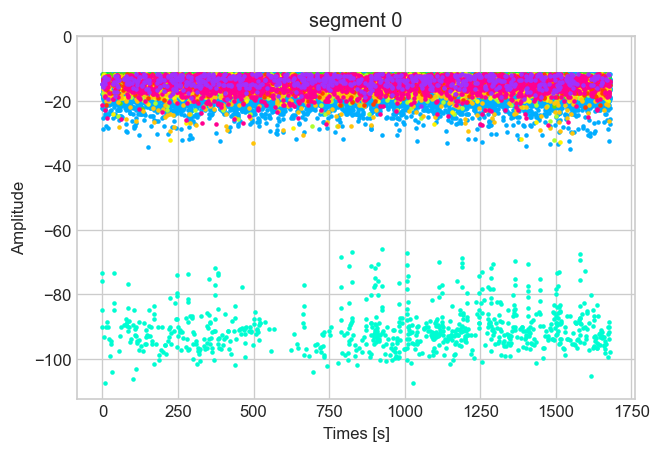

In [48]:
waveforms_ch = load_waveforms_extractors(OUTPUT_FOLDER)
ch=2038 # channel example
sw.plot_amplitudes_timeseries(waveforms_ch[ch])